In [24]:
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pickle

In [15]:
# Lista de arquivos CSV
appPath = "../data/itens/itens"
# , f"{appPath}/itens-parte2.csv", f"{appPath}/itens-parte3.csv"
csv_files = [f"{appPath}/itens-parte3.csv"]

# Concatenar os CSVs em um único DataFrame
df_artigos = pd.concat([pd.read_csv(file) for file in csv_files])

# Visualizar as primeiras linhas
df_artigos.head()

,page,url,issued,modified,title,body,caption
0,b2d67f99-e758-4719-adde-53926854ae38,http://g1.globo.com/sp/sao-paulo/eleicoes/2022...,2022-05-03 19:38:56+00:00,2022-05-03 20:54:49+00:00,Lula compara Arthur Lira a imperador do Japão,Ex-presidente Lula discursa em evento do Solid...,Petista voltou a criticar presidente da Câmara...
1,ddd9ba15-6026-4a9a-9204-08946b27be64,http://g1.globo.com/sp/sao-paulo/eleicoes/2022...,2022-05-04 16:54:14+00:00,2022-05-04 16:54:15+00:00,Voto facultativo terá peso inédito na eleição ...,Detalhe da urna eletrônica e a tecla confirma\...,Quantidade de eleitores de 16 a 17 anos e acim...
2,a06f8a15-b2ca-4363-b060-b821a158e35b,http://g1.globo.com/sp/sao-paulo/eleicoes/2022...,2022-05-23 19:18:56+00:00,2022-05-23 20:43:51+00:00,PT confirma conversa com economista Pérsio Ari...,"A presidente do PT, Gleisi Hoffmann, durante e...","Segundo Gleisi Hoffmann, Aloizio Mercadante te..."
3,55ab912a-2bac-46d9-9fcf-8e9be376f1b3,http://g1.globo.com/sp/sao-paulo/eleicoes/2022...,2022-08-11 13:12:31+00:00,2022-08-12 01:32:24+00:00,Ato pela democracia recorda mortos na ditadur...,Carta em defesa da democracia foi lida nesta q...,Evento reuniu milhares dentro e fora da Faculd...
4,6d7d0faf-58ce-43b7-bd22-b62a56e1fc41,http://g1.globo.com/politica/noticia/2022/01/2...,2022-01-28 21:32:08+00:00,2022-01-29 01:11:05+00:00,"Moro revela ter recebido R$ 3,6 milhões por 12...",Moro faz live para explicar pagamento por serv...,TCU apura possível 'conflito de interesse' na ...


In [16]:
# Criar uma nova coluna combinando título e corpo do artigo
df_artigos['text'] = df_artigos['title'].fillna('') + " " + df_artigos['body'].fillna('')

In [17]:
vectorizer = TfidfVectorizer(max_features=100_000)  # Limit features to reduce memory usage
tfidf_matrix = vectorizer.fit_transform(df_artigos['text'])

In [20]:
svd = TruncatedSVD(n_components=50) # , random_state=42
tfidf_reduced = svd.fit_transform(tfidf_matrix)

In [21]:
TOP_N = 10
similar_articles = {}

print("⚡ Computing similarities row by row...")

for idx in range(tfidf_reduced.shape[0]):
    if idx % 5000 == 0:
        print(f"Processing row {idx} / {tfidf_reduced.shape[0]}...")

    # Compute similarity only for the current row
    sim_scores = cosine_similarity(tfidf_reduced[idx:idx+1], tfidf_reduced)[0]  

    # Get Top-N most similar articles (excluding itself)
    top_indices = np.argsort(sim_scores)[-TOP_N-1:-1][::-1]  
    similar_articles[df_artigos.iloc[idx]['page']] = list(df_artigos.iloc[top_indices]['page'])

⚡ Computing similarities row by row...
Processing row 0 / 55603...
Processing row 5000 / 55603...
Processing row 10000 / 55603...
Processing row 15000 / 55603...
Processing row 20000 / 55603...
Processing row 25000 / 55603...
Processing row 30000 / 55603...
Processing row 35000 / 55603...
Processing row 40000 / 55603...
Processing row 45000 / 55603...
Processing row 50000 / 55603...
Processing row 55000 / 55603...


/home/heijimor/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


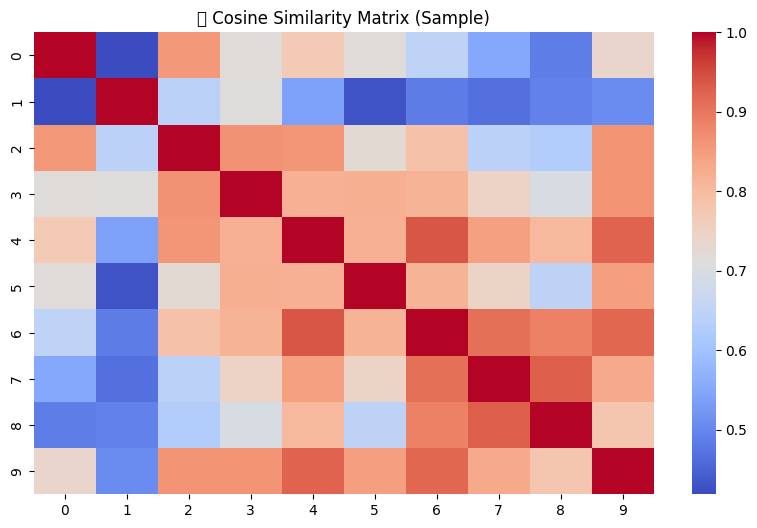

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(cosine_similarity(tfidf_reduced[:10], tfidf_reduced[:10]), cmap="coolwarm", annot=False)
plt.title("🔎 Cosine Similarity Matrix (Sample)")
plt.show()

In [27]:
with open("top_n_article_similarity.pkl", "wb") as f:
    pickle.dump(similar_articles, f)
print("Top-N article similarity saved!")

Top-N article similarity saved!


In [31]:
# Carregar o arquivo .pkl
with open("top_n_article_similarity.pkl", "rb") as f:
    loaded_similar_articles = pickle.load(f)

# Verificar se os dados foram carregados corretamente
print("Top-N articles loaded from .pkl:")
# Exibir as primeiras 5 chaves como exemplo
print(list(loaded_similar_articles.keys())[:5]) 

article_id = 'df57c369-00ec-43ac-a626-24916550575e'  # O ID do artigo de interesse

# Obter os artigos mais similares para esse artigo
recommended_articles = loaded_similar_articles.get(article_id, [])

# Mostrar os artigos recomendados
if recommended_articles:
    print(f"Artigos recomendados para o artigo {article_id}:")
    for idx, rec_article in enumerate(recommended_articles, 1):
        print(f"{idx}. {rec_article}")
else:
    print(f"Nenhum artigo semelhante encontrado para o artigo {article_id}.")

Top-N articles loaded from .pkl:
['b2d67f99-e758-4719-adde-53926854ae38', 'ddd9ba15-6026-4a9a-9204-08946b27be64', 'a06f8a15-b2ca-4363-b060-b821a158e35b', '55ab912a-2bac-46d9-9fcf-8e9be376f1b3', '6d7d0faf-58ce-43b7-bd22-b62a56e1fc41']
Artigos recomendados para o artigo df57c369-00ec-43ac-a626-24916550575e:
1. ffafb005-2165-453b-8475-0e3cf48edcdd
2. 3392d5e5-cea6-4d92-9520-b59d80a05941
3. 8ba5f02d-229f-49e7-b005-2cafed80e2ed
4. 796cb19b-5dfa-4346-a7f8-945595cc0d59
5. 56b5be93-e82d-4f86-8a0c-8070eb73c6a7
6. 49bed47c-57c2-42f6-9b0f-01a89524fcb4
7. 9cd0d8da-b33d-412d-8f2b-4f1532b4e2b0
8. 3d384fdd-76ff-4787-82f5-e3530c0785b2
9. e0734c8d-0a7a-43ff-91e0-102cf9eaae3a
10. 9519ac21-173b-479d-b7e0-26168e9a1b4b
